# Proximity Forest: Smaller epitope

even smaller

In [1]:
import numpy as np
import pandas as pd
from tcrdist.repertoire import TCRrep
from util import get_train_dataset, ProximityTreeClassifier, calculate_tcr_dist_multiple_chains
from sklearn.model_selection import train_test_split
from util import ProximityForestClassifier, calculate_tcr_dist2, calculate_tcr_dist2_cached
from sklearn.metrics import accuracy_score
from sklearn import metrics
from util import plot_roc_curve, get_epitope_df, evaluate, get_features, fix_test, calculate_tcr_dist2_cached
from sklearn.ensemble import RandomForestClassifier

In [2]:
df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')

rename_columns = {
    'antigen.epitope': 'epitope',
    'cdr3.alpha': 'CDR3_alfa',
    'v.alpha': 'TRAV',
    'j.alpha': 'TRAJ',
    'cdr3.beta': 'CDR3_beta',
    'v.beta': 'TRBV',
    'j.beta': 'TRBJ',
}

df_vdjdb = df_vdjdb.rename(columns=rename_columns)
df_vdjdb = df_vdjdb[rename_columns.values()]

# get all "epitope" names that have "CDR3_alfa" or "CDR3_beta" as NaN
nan_epitopes = df_vdjdb[df_vdjdb['CDR3_alfa'].isna() | df_vdjdb['CDR3_beta'].isna()]['epitope'].unique()
print(f"There are {len(nan_epitopes)} epitopes with NaN values in the CDR3_alfa or CDR3_beta columns")
# drop all rows that have an "epitope" name that is in "nan_epitopes"
df_vdjdb = df_vdjdb[~df_vdjdb['epitope'].isin(nan_epitopes)]

There are 518 epitopes with NaN values in the CDR3_alfa or CDR3_beta columns


C:\Users\arnod\AppData\Local\Temp/ipykernel_22928/19310559.py:1: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


In [3]:
# print the counts of those epitopes that have 100-200 samples, don't print the others
print(df_vdjdb['epitope'].value_counts().loc[lambda x: x.between(20, 80)])

NQKLIANQF      77
RTLNAWVKV      47
LLFGYPVYV      39
AYAQKIFKI      39
SLFNTVATLY     38
FLYALALLL      38
FLASKIGRLV     34
VYFLQSINF      29
LLDFVRFMGV     26
RVAGDSGFAAY    24
Name: epitope, dtype: int64


In [26]:
current_epitope = 'NQKLIANQF'

In [27]:
epitope_df = get_epitope_df(current_epitope, species='HomoSapiens')
# epitope_df = epitope_df.sample(100) # TODO: remove
print(f"Created a dataframe with {len(epitope_df)} samples for the epitope {current_epitope}")

Number of negative samples changed from 54786 to 54725 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 0, both: 77, none: 0
Negative samples: alpha only: 7169, beta only: 20671, both: 26885, none: 0
Created a dataframe with 154 samples for the epitope NQKLIANQF


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


In [28]:
y_column = 'reaction'
x_columns = ['CDR3_alfa', 'TRAV', 'TRAJ', 'CDR3_beta', 'TRBV', 'TRBJ']
epitope_df = epitope_df[x_columns + [y_column]]
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42) # not using this, no nan -> KFold

epitope_x = epitope_df[x_columns]
epitope_y = epitope_df[y_column]

In [29]:
y = epitope_y
x_features = get_features(epitope_x)
# features introduce NaN values, set them to 0
x_features = np.nan_to_num(x_features, nan=0)

### RandomForest

In [30]:
# check the performance on a RandomForest classifier
clf = RandomForestClassifier(n_estimators=100)
evaluate(clf, x_features, y)

[0.71710526 0.70625    0.56041667 0.70726496 0.60491071]
ROC: 0.659 (+/- 0.128)


# Proximity Forest

In [18]:
# # np_x = epitope_x.to_numpy()
# # np_y = epitope_y.to_numpy()
#
# np_x = epitope_x
# np_y = epitope_y
#
# model = ProximityForestClassifier(reduce_features=False, distance_measure=calculate_tcr_dist2_cached,
#                                   distance_kwargs={"nan_distance": 0, 'organism': "mouse"}, multithreaded=False)
#
# evaluate(clf, np_x, np_y)

In [31]:
np_x = epitope_x
np_y = epitope_y

Predicting: 100%|██████████| 100/100 [11:11<00:00,  6.71s/it]


0.4838709677419355


Predicting: 100%|██████████| 100/100 [00:01<00:00, 83.68it/s]


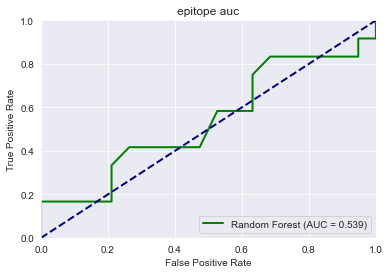

ROC AUC: 0.5394736842105263


In [33]:
model = ProximityForestClassifier(reduce_features=False, distance_measure=calculate_tcr_dist2_cached,
                                  distance_kwargs={"nan_distance": 0, 'organism': "human"}, multithreaded=False)


# split np_x and np_y into train and test
train_X, val_X, train_y, val_y = train_test_split(np_x, np_y, test_size=0.2, random_state=42)

model.fit(train_X, train_y)


predictions = model.predict(val_X)

print(accuracy_score(val_y, predictions))

predictions = model.predict_proba(val_X)
fpr, tpr, thresholds = metrics.roc_curve(val_y, predictions[:, 1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plot_roc_curve(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})', title="epitope auc")
print(f"ROC AUC: {roc_auc}")

In [34]:
print(f"Train size: {len(train_X)}")
print(f"Test size: {len(val_X)}")

Train size: 123
Test size: 31


In [35]:
def get_auc(clf, np_x, np_y, seed):
    train_X, val_X, train_y, val_y = train_test_split(np_x, np_y, test_size=0.2, random_state=seed)

    clf.fit(train_X, train_y)

    # predictions = clf.predict(val_X)
    # print(accuracy_score(val_y, predictions))

    predictions = model.predict_proba(val_X)
    fpr, tpr, thresholds = metrics.roc_curve(val_y, predictions[:, 1], pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc}")
    return roc_auc

In [36]:
aucs = []
for i in range(5):
    aucs.append(get_auc(model, np_x, np_y, i))

Predicting: 100%|██████████| 200/200 [06:43<00:00,  2.02s/it]


ROC AUC: 0.8025210084033613


Predicting: 100%|██████████| 300/300 [02:37<00:00,  1.91it/s]


ROC AUC: 0.7794117647058824


Predicting: 100%|██████████| 400/400 [01:27<00:00,  4.55it/s]


ROC AUC: 0.8048245614035088


Predicting: 100%|██████████| 500/500 [00:44<00:00, 11.26it/s] 


ROC AUC: 0.8250000000000001


Predicting: 100%|██████████| 600/600 [00:23<00:00, 25.28it/s] 

ROC AUC: 0.7226890756302521


In [38]:
print(aucs)
print(f"ROC: {np.mean(aucs):.3f} (+/- {np.std(aucs) * 2:.3f})")

[0.8025210084033613, 0.7794117647058824, 0.8048245614035088, 0.8250000000000001, 0.7226890756302521]
ROC: 0.787 (+/- 0.070)
